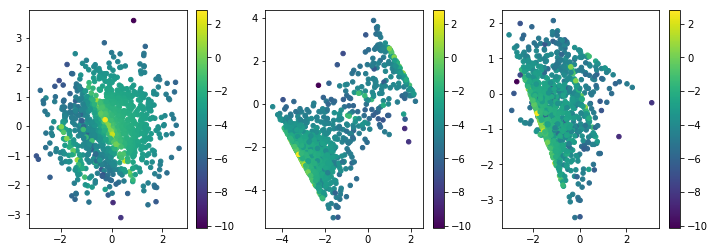

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from planar_numpy import planar_flow, to_simplex
from scipy.stats import multivariate_normal, dirichlet
from dirichlet import simplex

D = 2;
n = 1000;
n_plot = 1000;

# planar flow layer 1 params
u1 = -np.expand_dims(np.array([-3.173, -2.739]), 1);
w1 = -np.expand_dims(np.array([1.898, 1.038]), 1);
b1 = -2.004; 

# planar flow layer 2 params
u2 = -np.expand_dims(np.array([-1.407, -1.804]), 1);
w2 = -np.expand_dims(np.array([1.115, 2.369]), 1);
b2 = -.848; 

z0 = np.random.normal(0, 1, (D, n));
dist = multivariate_normal(np.zeros((2,)), np.eye(2));
base_logq = dist.logpdf(z0.T);
size = 20*np.ones((n_plot,));

z1, log_det_jac1 = planar_flow(z0, u1, w1, b1);
z2, log_det_jac2 = planar_flow(z1, u2, w2, b2);

logq = base_logq - log_det_jac1 - log_det_jac2;

fig = plt.figure(figsize=(12,4));
fig.add_subplot(1,3,1);
plt.scatter(z0[0,:n_plot], z0[1,:n_plot], size, logq[:n_plot]);
plt.colorbar();
fig.add_subplot(1,3,2);
plt.scatter(z1[0,:n_plot], z1[1,:n_plot], size, logq[:n_plot]);
plt.colorbar();
fig.add_subplot(1,3,3);
plt.scatter(z2[0,:n_plot], z2[1,:n_plot], size, logq[:n_plot]);
plt.colorbar();



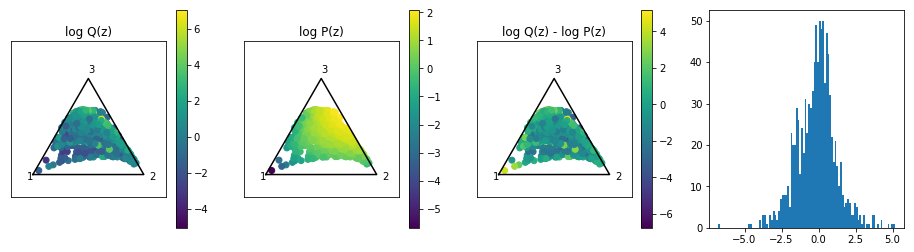

-0.138370594282


In [2]:
y, log_det_jac_simp1, log_det_jac_simp2 = to_simplex(z2);

logq = base_logq - log_det_jac1 - log_det_jac2 - log_det_jac_simp1;

alpha = np.array([1,2,3]);
dist_targ = dirichlet(alpha);
logp = dist_targ.logpdf(y);

KL_ptwise = logq-logp;

fig = plt.figure(figsize=(16,4));
fig.add_subplot(1,4,1);
simplex.scatter(y[:,:n_plot].T, connect=False, c=logq[:n_plot]);
plt.title('log Q(z)')
plt.colorbar();
fig.add_subplot(1,4,2);
simplex.scatter(y[:,:n_plot].T, connect=False, c=logp[:n_plot]);
plt.title('log P(z)')
plt.colorbar();
fig.add_subplot(1,4,3);
simplex.scatter(y[:,:n_plot].T, connect=False, c=KL_ptwise[:n_plot]);
plt.title('log Q(z) - log P(z)')
plt.colorbar();
fig.add_subplot(1,4,4);
plt.hist(KL_ptwise, 100);
plt.show();

KL = np.mean(logq - logp);
print(KL);

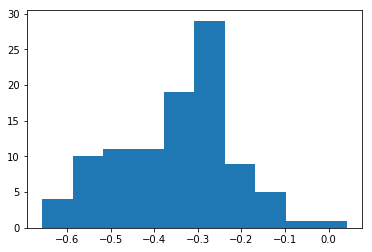

In [3]:
nsamps = 100;
n_i = n // 10;
KLs = np.zeros((nsamps,));
inds = np.arange(nsamps);
for i in range(nsamps):
    inds_i = np.random.choice(inds, n_i);
    KLs[i] = np.mean(logq[inds_i] - logp[inds_i]);
plt.figure();
plt.hist(KLs);
plt.show();

In [4]:
import lasagne
import theano
import theano.tensor as T
from lasagne.layers import InputLayer
import sys
sys.path.append('utils/');
from normalizing_flow_utils import PlanarFlow
from layers_utils import ExpLayer, SimplexBijectionLayer
from numpy.random import RandomState

np.random.seed(222)
lasagne.random.set_rng(RandomState(222))
z0_th = T.matrix("z") #input

l_hid = InputLayer(shape=(None, D), input_var=z0_th)

out0 = lasagne.layers.get_output(l_hid);
l_hid = PlanarFlow(l_hid, w=lasagne.init.Constant(w1.T), u=lasagne.init.Constant(u1.T), b=lasagne.init.Constant(b1));
logdet = l_hid.det(out0)
us_fn = theano.function(inputs=[], outputs=[l_hid.u0, l_hid.u]);
print(us_fn());

out1 = lasagne.layers.get_output(l_hid)
l_hid = PlanarFlow(l_hid, w=lasagne.init.Constant(w2.T), u=lasagne.init.Constant(u2.T), b=lasagne.init.Constant(b2));
logdet += l_hid.det(out1)
        
out2 = lasagne.layers.get_output(l_hid)
l_hid = SimplexBijectionLayer(l_hid)
out_simplex = lasagne.layers.get_output(l_hid)
logdet += l_hid.det(out2)

y_fn = theano.function(inputs=[z0_th], outputs=out_simplex);
sum_log_det_fn = theano.function(inputs=[z0_th], outputs=logdet);

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



ImportError: Could not import Theano.

Please make sure you install a recent enough version of Theano.  See
section 'Install from PyPI' in the installation docs for more details:
http://lasagne.readthedocs.org/en/latest/user/installation.html#install-from-pypi


In [ ]:
y_lasagne = y_fn(z0.T);
sum_log_dets = sum_log_det_fn(z0.T);
print(sum_log_dets)
simplex.scatter(y_lasagne[:n_plot,:], connect=False, c=logq[:n_plot]);

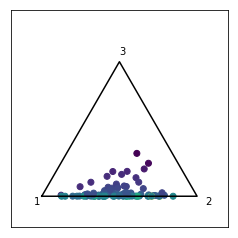

[[2.79105610e-01 7.16244246e-01 4.65014425e-03]
 [8.00611161e-01 1.98764773e-01 6.24065475e-04]
 [5.28565617e-01 4.34639568e-01 3.67948153e-02]
 [6.91392803e-01 3.03043063e-01 5.56413413e-03]
 [6.74556438e-01 3.17449506e-01 7.99405602e-03]
 [6.07409635e-01 3.92073739e-01 5.16626260e-04]
 [2.40441068e-01 7.59558918e-01 1.38196664e-08]
 [1.90294142e-01 5.64505847e-01 2.45200011e-01]
 [6.31618803e-01 2.64336167e-01 1.04045030e-01]
 [4.52407105e-01 5.47469404e-01 1.23491058e-04]
 [6.28882100e-01 3.70109942e-01 1.00795755e-03]
 [3.12460742e-01 6.87332215e-01 2.07043389e-04]
 [7.17454689e-01 2.73154815e-01 9.39049597e-03]
 [5.34978757e-01 4.50665290e-01 1.43559529e-02]
 [3.17889901e-01 6.25337702e-01 5.67723968e-02]
 [6.86866891e-01 3.11065220e-01 2.06788876e-03]
 [3.95290092e-01 6.03511247e-01 1.19866039e-03]
 [8.71597198e-01 1.20605521e-01 7.79728161e-03]
 [4.39867124e-01 5.46718236e-01 1.34146399e-02]
 [3.84123918e-01 6.15764488e-01 1.11594421e-04]
 [5.34489650e-01 4.64436474e-01 1.073875

In [22]:
alpha = np.array([4.0340782, 4.2959002, .30056044]);
dist = dirichlet(alpha);
y = dist.rvs(100);
logp = dist.logpdf(y.T);
simplex.scatter(y, connect=False, c=logp[:n_plot]);
plt.show();
print(y);